In [147]:
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras import backend as keras
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
from keras.applications import VGG16, Xception
from keras.layers import Input, Concatenate
from keras.layers.advanced_activations import PReLU

from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from skimage import exposure
from scipy.ndimage import rotate

from IPython.display import SVG
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data Loading & Cleaning

In [2]:
training = pd.read_csv("new_training.csv")
training_labels = pd.read_csv("new_training_labels.csv")
validation = pd.read_csv("new_validation.csv")
validation_labels = pd.read_csv("new_validation_labels.csv")

In [3]:
training.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,0.960784,0.960784,0.960784,0.980392,0.898039,0.490196,0.258824,0.243137,0.235294,0.227451,...,0.286275,0.364706,0.537255,0.592157,0.529412,0.447059,0.376471,0.337255,0.325490,0.352941
1,0.380392,0.352941,0.258824,0.266667,0.309804,0.286275,0.262745,0.270588,0.227451,0.262745,...,0.909804,0.917647,0.823529,0.690196,0.243137,0.062745,0.094118,0.082353,0.074510,0.094118
2,0.960784,0.960784,0.960784,0.988235,0.823529,0.372549,0.180392,0.164706,0.168627,0.176471,...,0.200000,0.262745,0.325490,0.341176,0.298039,0.309804,0.372549,0.533333,0.588235,0.584314
3,0.890196,0.878431,0.878431,0.745098,0.537255,0.525490,0.505882,0.517647,0.756863,0.592157,...,0.047059,0.043137,0.031373,0.043137,0.043137,0.035294,0.031373,0.035294,0.035294,0.039216
4,0.266667,0.168627,0.141176,0.145098,0.141176,0.141176,0.133333,0.141176,0.125490,0.113725,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
training.shape

(1712, 9216)

In [5]:
training_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,62.769702,35.515098,30.515745,37.036460,56.987915,35.819370,68.246468,35.819370,35.993191,37.036460,...,47.555404,52.858894,60.334979,72.637277,37.514213,73.853957,48.164085,68.072851,48.164085,79.027064
1,65.397652,36.969869,31.026711,38.423530,59.169878,38.432780,71.321745,37.306950,37.368044,38.807371,...,50.200745,57.207272,66.488720,71.354748,31.737636,72.866660,49.834773,72.110704,51.369593,77.768923
2,64.762466,34.933389,31.859729,37.191483,59.924211,35.901113,70.569383,35.255964,37.988571,37.514057,...,49.924331,54.288217,63.472602,72.997534,40.246376,74.288120,50.246977,69.449143,52.182135,83.320060
3,63.701517,35.300414,29.674483,36.040276,57.783724,35.793655,69.126069,35.793655,34.852414,36.779586,...,48.660414,48.368552,60.496000,68.340966,32.880000,69.573517,47.181241,64.642207,47.181241,73.518897
4,63.709063,37.328506,28.822177,35.667342,55.125873,37.882329,72.569013,39.266734,37.128608,36.774987,...,47.373266,58.648405,60.940253,79.414177,29.376000,77.753013,46.819443,73.322734,46.542684,84.951797


In [6]:
training_labels.shape

(1712, 30)

In [7]:
validation.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,0.133333,0.137255,0.121569,0.113725,0.117647,0.109804,0.145098,0.145098,0.121569,0.113725,...,0.439216,0.447059,0.435294,0.549020,0.607843,0.678431,0.968627,1.000000,1.000000,1.000000
1,0.380392,0.352941,0.341176,0.321569,0.298039,0.274510,0.270588,0.298039,0.294118,0.286275,...,0.090196,0.086275,0.094118,0.133333,0.160784,0.141176,0.164706,0.188235,0.203922,0.215686
2,0.003922,0.027451,0.137255,0.282353,0.356863,0.407843,0.470588,0.443137,0.435294,0.439216,...,0.274510,0.203922,0.250980,0.094118,0.019608,0.141176,0.254902,0.450980,0.768627,0.964706
3,0.380392,0.349020,0.396078,0.494118,0.521569,0.501961,0.478431,0.482353,0.454902,0.423529,...,0.650980,0.643137,0.647059,0.643137,0.647059,0.639216,0.635294,0.639216,0.639216,0.643137
4,0.156863,0.176471,0.164706,0.133333,0.141176,0.137255,0.129412,0.121569,0.113725,0.113725,...,0.066667,0.074510,0.101961,0.121569,0.101961,0.125490,0.117647,0.113725,0.125490,0.137255


In [8]:
validation.shape

(428, 9216)

In [9]:
validation_labels.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,66.904101,36.080506,29.805873,35.904911,59.519696,37.487089,74.464405,35.553114,37.366177,37.311190,...,48.970329,58.409924,61.805165,79.508354,32.794937,78.101772,48.091139,75.288608,47.915544,83.727797
1,66.059520,36.848640,26.589120,37.706880,60.052800,37.706880,72.495360,37.706880,32.165760,37.706880,...,45.466560,53.581440,63.914880,77.607360,30.879360,78.036480,45.894720,72.029760,47.182080,86.187840
2,65.980239,36.897008,30.275860,38.540757,56.548894,39.995879,72.830719,36.221724,38.144297,39.133584,...,53.853093,60.415312,62.822043,78.300361,33.773500,79.795506,49.933278,79.545298,49.689172,79.911456
3,66.968195,39.960195,29.646049,37.169951,61.038049,41.355707,72.897561,41.703805,35.575415,38.913561,...,48.830439,57.400195,59.992195,83.909463,33.482927,82.165854,48.132683,74.143220,47.434927,93.327610
4,67.077978,36.535912,28.650549,35.050549,58.909890,37.649582,75.617407,38.020923,36.818637,36.721582,...,46.843077,58.812484,66.335297,74.220659,25.680176,72.920967,46.471736,72.735297,45.967473,85.944615


In [10]:
validation.shape

(428, 9216)

Each row of the `training` and `validation` datasets represent an image. Each column is an individual pixel value. Need to convert all the columns in each row to a single numpy array.

In [11]:
training_1Darray = training.values

In [12]:
training_1Darray[0].shape

(9216,)

In [13]:
validation_1Darray = validation.values

In [14]:
validation_1Darray[0].shape

(9216,)

Normalize target labels to be between [-1, 1]

In [15]:
y_train, y_val = (training_labels - 48) / 48, (validation_labels - 48) / 48

In [16]:
y_train, y_val = y_train.astype(np.float32), y_val.astype(np.float32)

Pixel values of images already seem to be scaled between [0, 1]

Shape each image to dimensions of [96, 96, 1]

In [17]:
X_train, X_val = np.vstack(training_1Darray), np.vstack(validation_1Darray)
X_train, X_val = X_train.astype(np.float32), X_val.astype(np.float32)
X_train, X_val = X_train.reshape(-1, 96, 96, 1), X_val.reshape(-1, 96, 96, 1)
print(X_train[0].shape, X_val[0].shape)

(96, 96, 1) (96, 96, 1)


# Metrics

In [18]:
# RMSE
def rmse(y_true, y_pred):
    return keras.sqrt(keras.mean(keras.square(y_pred - y_true)))

# RMSE (convert back from normalized to original)
def rmse_96(y_true, y_pred):
    y_true_orig = y_true * 48 + 48
    y_pred_orig = y_pred * 48 + 48
    return keras.sqrt(keras.mean(keras.square(y_pred_orig - y_true_orig)))

# R^2
def r_squared(y_true, y_pred):
    SS_res = keras.sum(keras.square(y_true - y_pred))
    SS_tot = keras.sum(keras.square(y_true - keras.mean(y_true)))
    return (1 - SS_res / (SS_tot + keras.epsilon()))

# Baseline CNN - Only observations with complete labels, no data augmentation

## Drop observations with missing labels

In [19]:
X_train_nm = X_train[~np.isnan(y_train).any(axis=1)]
y_train_nm = y_train[~np.isnan(y_train).any(axis=1)]

X_val_nm = X_val[~np.isnan(y_val).any(axis=1)]
y_val_nm = y_val[~np.isnan(y_val).any(axis=1)]

print(X_train_nm.shape, y_train_nm.shape)
print(X_val_nm.shape, y_val_nm.shape)

(1712, 96, 96, 1) (1712, 30)
(428, 96, 96, 1) (428, 30)


In [20]:
"The training dataset is {}% of the original size, and the validation dataset is {}% of the original size when observations with missing labels are removed.".format(
    round((1692/5640)*100, 1), round((448/1409)*100, 1))

'The training dataset is 30.0% of the original size, and the validation dataset is 31.8% of the original size when observations with missing labels are removed.'

In [21]:
def baseline_CNN(num_filters, num_epochs):
    np.random.seed(666)

    # create model
    model = Sequential()
    model.add(Conv2D(num_filters, (3, 3), activation='relu', input_shape=(96, 96, 1)))
    model.add(Flatten())
    model.add(Dense(30))
    model.add(Activation("linear"))  # not necessary but want to be explicit
    
    return model    

In [22]:
model_nm = baseline_CNN(10, 20)

In [23]:
# compile model
model_nm.compile(loss=rmse, optimizer='adam', metrics=[rmse, rmse_96, r_squared])

# fit model
%time H = model_nm.fit(X_train_nm, y_train_nm, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_nm, y_val_nm), verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/20
 - 2s - loss: 0.5653 - rmse: 0.5653 - rmse_96: 27.1354 - r_squared: -4.1540e+00 - val_loss: 0.1248 - val_rmse: 0.1248 - val_rmse_96: 5.9922 - val_r_squared: 0.8979
Epoch 2/20
 - 1s - loss: 0.0958 - rmse: 0.0958 - rmse_96: 4.5968 - r_squared: 0.9382 - val_loss: 0.0889 - val_rmse: 0.0889 - val_rmse_96: 4.2665 - val_r_squared: 0.9484
Epoch 3/20
 - 1s - loss: 0.0593 - rmse: 0.0593 - rmse_96: 2.8454 - r_squared: 0.9764 - val_loss: 0.0550 - val_rmse: 0.0550 - val_rmse_96: 2.6396 - val_r_squared: 0.9801
Epoch 4/20
 - 1s - loss: 0.0488 - rmse: 0.0488 - rmse_96: 2.3418 - r_squared: 0.9843 - val_loss: 0.0565 - val_rmse: 0.0565 - val_rmse_96: 2.7136 - val_r_squared: 0.9790
Epoch 5/20
 - 1s - loss: 0.0389 - rmse: 0.0389 - rmse_96: 1.8676 - r_squared: 0.9900 - val_loss: 0.0504 - val_rmse: 0.0504 - val_rmse_96: 2.4203 - val_r_squared: 0.9833
Epoch 6/20
 - 1s - loss: 0.0370 - rmse: 0.0370 - rmse_96: 1.7741 - r_squared: 0.9909 - val_loss: 0.049

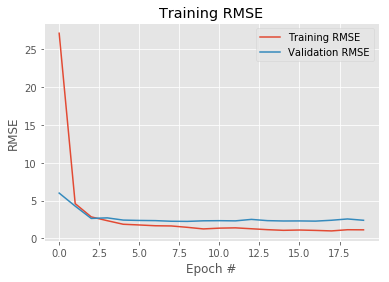

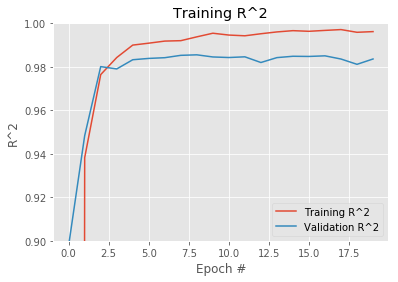

In [24]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("Training RMSE")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("Training R^2")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [25]:
# predict from model
predictions = model_nm.predict(X_val_nm, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_nm*48+48))**2)))**0.5))

RMSE of Predictions:    2.408942858463649


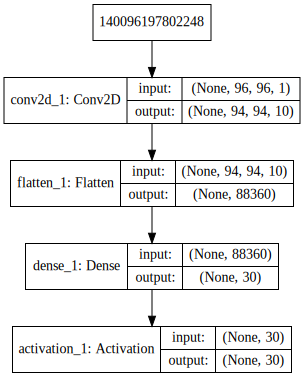

In [26]:
SVG(model_to_dot(model_nm, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

# Transfer Learning - VGG16 Fine Tuning

##  Only observations with complete labels, no data augmentation

## Early stopping on epochs specification

In [27]:
# preprocessing data similar to pre-trained VGG model
X_train_scale = training_1Darray - training_1Darray.mean()
X_val_scale = validation_1Darray - validation_1Darray.mean()

X_train_scale, X_val_scale = np.vstack(X_train_scale), np.vstack(X_val_scale)
X_train_scale, X_val_scale = X_train_scale.astype(np.float32), X_val_scale.astype(np.float32)
X_train_scale, X_val_scale = X_train_scale.reshape(-1, 96, 96, 1), X_val_scale.reshape(-1, 96, 96, 1)
print(X_train_scale[0].shape, X_val_scale[0].shape)

(96, 96, 1) (96, 96, 1)


In [28]:
# mimic 3 channels
X_train_vgg, X_val_vgg = np.tile(X_train_scale[:, :, :], [1, 1, 3]), np.tile(X_val_scale[:, :, :], [1, 1, 3])
print(X_train_vgg[0].shape, X_val_vgg[0].shape)

(96, 96, 3) (96, 96, 3)


In [29]:
# Drop missing values again
X_train_vgg = X_train_vgg[~np.isnan(y_train).any(axis=1)]
y_train_vgg = y_train[~np.isnan(y_train).any(axis=1)]

X_val_vgg = X_val_vgg[~np.isnan(y_val).any(axis=1)]
y_val_vgg = y_val[~np.isnan(y_val).any(axis=1)]

print(X_train_vgg.shape, y_train_vgg.shape)
print(X_val_vgg.shape, y_val_vgg.shape)

(1712, 96, 96, 3) (1712, 30)
(428, 96, 96, 3) (428, 30)


In [30]:
class FCHeadNet:
    @staticmethod
    def build(baseModel):
        np.random.seed(666)
        # Initialize head model from pre-trained model output
        # This is basically adapted from our baseline_CNN
        # Just with an extra layer
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(256, activation="relu")(headModel)
        #headModel = PReLU()(headModel)
        headModel = Dense(30, activation="linear")(headModel)
        
        return headModel        

In [31]:
# Load VGG16 network trained on ImageNet without head FC layers
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Initialize a new head consisting of FC layers to replace VGG16's head
headModel = FCHeadNet.build(baseModel)

# Create Frankenstein (attach new FC head to VGG16 body)
model = Model(inputs=baseModel.input, outputs=headModel)

In [32]:
# Loop over layers from VGG model and freeze them so they don't go through
# backpropagation
for layer in baseModel.layers:
    layer.trainable = False

In [33]:
# Compile our model
# Run a few epochs to warm up our new head (FC layers)
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train head of network for a few epochs allowing new FC layers to start to
# become initialized with actual "learned" values versus purely random values
%time H = model.fit(X_train_vgg, y_train_vgg, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_vgg, y_val_vgg), verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/20
 - 6s - loss: 0.1721 - rmse: 0.1721 - rmse_96: 8.2591 - r_squared: 0.6742 - val_loss: 0.0903 - val_rmse: 0.0903 - val_rmse_96: 4.3337 - val_r_squared: 0.9469
Epoch 2/20
 - 5s - loss: 0.0778 - rmse: 0.0778 - rmse_96: 3.7329 - r_squared: 0.9604 - val_loss: 0.0747 - val_rmse: 0.0747 - val_rmse_96: 3.5858 - val_r_squared: 0.9636
Epoch 3/20
 - 5s - loss: 0.0649 - rmse: 0.0649 - rmse_96: 3.1165 - r_squared: 0.9724 - val_loss: 0.0692 - val_rmse: 0.0692 - val_rmse_96: 3.3193 - val_r_squared: 0.9687
Epoch 4/20
 - 4s - loss: 0.0593 - rmse: 0.0593 - rmse_96: 2.8445 - r_squared: 0.9770 - val_loss: 0.0630 - val_rmse: 0.0630 - val_rmse_96: 3.0245 - val_r_squared: 0.9740
Epoch 5/20
 - 5s - loss: 0.0535 - rmse: 0.0535 - rmse_96: 2.5669 - r_squared: 0.9813 - val_loss: 0.0604 - val_rmse: 0.0604 - val_rmse_96: 2.9011 - val_r_squared: 0.9761
Epoch 6/20
 - 5s - loss: 0.0508 - rmse: 0.0508 - rmse_96: 2.4362 - r_squared: 0.9831 - val_loss: 0.0588 - va

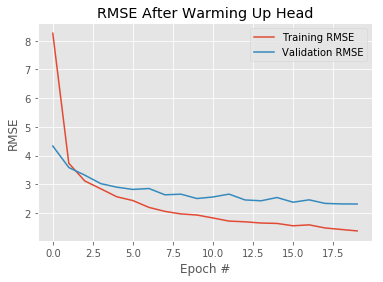

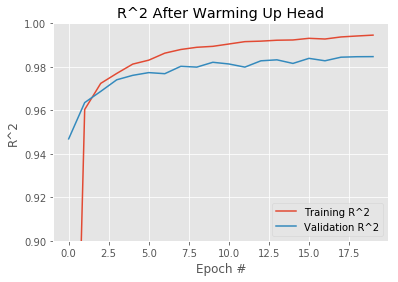

In [34]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [35]:
# predict from model
predictions = model.predict(X_val_vgg, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_vgg*48+48))**2)))**0.5))

RMSE of Predictions:    2.326183661776131


In [36]:
# After warming up the head FC layers, unfreeze the final set of CONV layers
# to train them
for layer in baseModel.layers[15:]:
    layer.trainable=True

In [37]:
# Recompile our model to train some of the CONV layers
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train model again to fine-tune both the final few CONV layers along with the head
# of FC layers
%time H = model.fit(X_train_vgg, y_train_vgg, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_vgg, y_val_vgg), verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/20
 - 7s - loss: 0.0912 - rmse: 0.0912 - rmse_96: 4.3784 - r_squared: 0.9206 - val_loss: 0.0607 - val_rmse: 0.0607 - val_rmse_96: 2.9146 - val_r_squared: 0.9758
Epoch 2/20
 - 6s - loss: 0.0562 - rmse: 0.0562 - rmse_96: 2.6987 - r_squared: 0.9792 - val_loss: 0.0492 - val_rmse: 0.0492 - val_rmse_96: 2.3627 - val_r_squared: 0.9841
Epoch 3/20
 - 6s - loss: 0.0463 - rmse: 0.0463 - rmse_96: 2.2224 - r_squared: 0.9859 - val_loss: 0.0440 - val_rmse: 0.0440 - val_rmse_96: 2.1134 - val_r_squared: 0.9872
Epoch 4/20
 - 6s - loss: 0.0403 - rmse: 0.0403 - rmse_96: 1.9347 - r_squared: 0.9893 - val_loss: 0.0376 - val_rmse: 0.0376 - val_rmse_96: 1.8043 - val_r_squared: 0.9906
Epoch 5/20
 - 6s - loss: 0.0354 - rmse: 0.0354 - rmse_96: 1.7016 - r_squared: 0.9918 - val_loss: 0.0345 - val_rmse: 0.0345 - val_rmse_96: 1.6556 - val_r_squared: 0.9920
Epoch 6/20
 - 6s - loss: 0.0325 - rmse: 0.0325 - rmse_96: 1.5586 - r_squared: 0.9931 - val_loss: 0.0341 - va

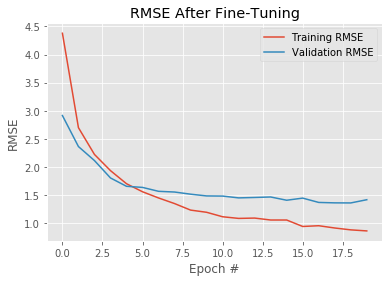

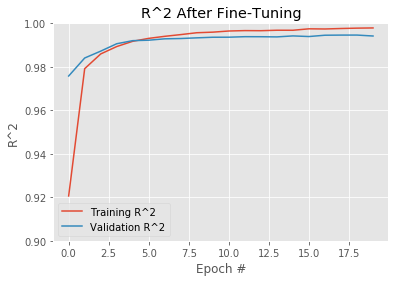

In [38]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [39]:
# predict from model
predictions = model.predict(X_val_vgg, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_vgg*48+48))**2)))**0.5))

RMSE of Predictions:    1.436358786663652


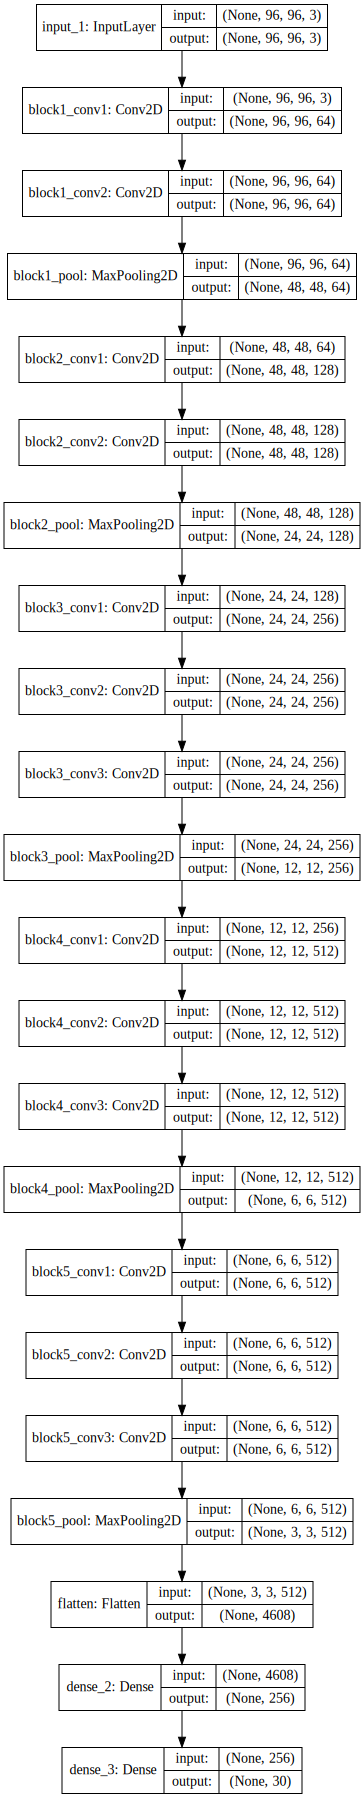

In [40]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

# Transfer Learning - VGG16 Fine Tuning

##  Only observations with complete labels

## Early stopping on epochs specification & Data Augmentation (Histogram Equalization)

In [41]:
# preprocessing data similar to pre-trained VGG model
X_train_scale = training_1Darray - training_1Darray.mean()
X_val_scale = validation_1Darray - validation_1Darray.mean()

In [42]:
X_train_scale, X_val_scale = np.vstack(X_train_scale), np.vstack(X_val_scale)
X_train_scale, X_val_scale = X_train_scale.astype(np.float32), X_val_scale.astype(np.float32)
X_train_scale, X_val_scale = X_train_scale.reshape(-1, 96, 96, 1), X_val_scale.reshape(-1, 96, 96, 1)
print(X_train_scale[0].shape, X_val_scale[0].shape)

(96, 96, 1) (96, 96, 1)


In [43]:
# Make copies of the training dataset to apply augmentation
# We will apply augmentation on the copy and combine with original
# dataset to increase dataset size
X_train_scale2 = X_train_scale.copy()

def hist_equal(im):
    img = im.reshape(96, 96)
    img_aug = exposure.equalize_hist(img)
    return img_aug

for img in range(0, len(X_train_scale2)):
    X_train_scale2[img] = hist_equal(X_train_scale2[img]).reshape(96, 96, 1)

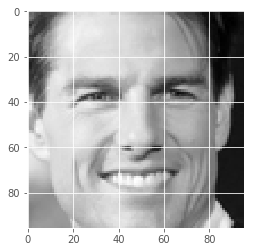

In [44]:
# QC - Original Image
plt.imshow(X_train_scale[1].reshape(96, 96), cmap='gray')

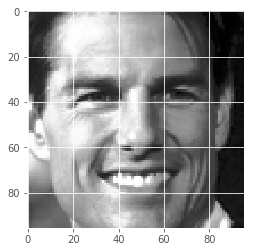

In [45]:
# QC - Image After Histogram Equalization
plt.imshow(X_train_scale2[1].reshape(96, 96), cmap='gray')

In [46]:
# Combine datasets
X_train_combined = np.concatenate((X_train_scale, X_train_scale2), axis=0)
y_train_combined = np.concatenate((y_train, y_train), axis=0)

In [47]:
# mimic 3 channels
X_train_vgg, X_val_vgg = np.tile(X_train_combined[:, :, :], [1, 1, 3]), np.tile(X_val_scale[:, :, :], [1, 1, 3])
print(X_train_vgg[0].shape, X_val_vgg[0].shape)

(96, 96, 3) (96, 96, 3)


In [48]:
# Drop missing values again
X_train_vgg = X_train_vgg[~np.isnan(y_train_combined).any(axis=1)]
y_train_vgg = y_train_combined[~np.isnan(y_train_combined).any(axis=1)]

X_val_vgg = X_val_vgg[~np.isnan(y_val).any(axis=1)]
y_val_vgg = y_val[~np.isnan(y_val).any(axis=1)]

print(X_train_vgg.shape, y_train_vgg.shape)
print(X_val_vgg.shape, y_val_vgg.shape)

(3424, 96, 96, 3) (3424, 30)
(428, 96, 96, 3) (428, 30)


In [49]:
# Shuffle data so augmented data aren't all together
np.random.seed(666)
shuffle = np.random.permutation(len(X_train_vgg))
X_train_vgg = X_train_vgg[shuffle]
y_train_vgg = y_train_vgg[shuffle]

In [50]:
# Load VGG16 network trained on ImageNet without head FC layers
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Initialize a new head consisting of FC layers to replace VGG16's head
headModel = FCHeadNet.build(baseModel)

# Create Frankenstein (attach new FC head to VGG16 body)
model = Model(inputs=baseModel.input, outputs=headModel)

In [51]:
# Loop over layers from VGG model and freeze them so they don't go through
# backpropagation
for layer in baseModel.layers:
    layer.trainable = False

In [52]:
# Compile our model
# Run a few epochs to warm up our new head (FC layers)
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train head of network for a few epochs allowing new FC layers to start to
# become initialized with actual "learned" values versus purely random values
%time H = model.fit(X_train_vgg, y_train_vgg, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_vgg, y_val_vgg), verbose=2)

Train on 3424 samples, validate on 428 samples
Epoch 1/20
 - 9s - loss: 0.1257 - rmse: 0.1257 - rmse_96: 6.0323 - r_squared: 0.8147 - val_loss: 0.0727 - val_rmse: 0.0727 - val_rmse_96: 3.4900 - val_r_squared: 0.9655
Epoch 2/20
 - 8s - loss: 0.0652 - rmse: 0.0652 - rmse_96: 3.1304 - r_squared: 0.9722 - val_loss: 0.0640 - val_rmse: 0.0640 - val_rmse_96: 3.0740 - val_r_squared: 0.9732
Epoch 3/20
 - 8s - loss: 0.0552 - rmse: 0.0552 - rmse_96: 2.6481 - r_squared: 0.9801 - val_loss: 0.0589 - val_rmse: 0.0589 - val_rmse_96: 2.8279 - val_r_squared: 0.9773
Epoch 4/20
 - 8s - loss: 0.0493 - rmse: 0.0493 - rmse_96: 2.3652 - r_squared: 0.9842 - val_loss: 0.0542 - val_rmse: 0.0542 - val_rmse_96: 2.6002 - val_r_squared: 0.9808
Epoch 5/20
 - 8s - loss: 0.0450 - rmse: 0.0450 - rmse_96: 2.1604 - r_squared: 0.9868 - val_loss: 0.0507 - val_rmse: 0.0507 - val_rmse_96: 2.4333 - val_r_squared: 0.9832
Epoch 6/20
 - 8s - loss: 0.0418 - rmse: 0.0418 - rmse_96: 2.0059 - r_squared: 0.9886 - val_loss: 0.0511 - va

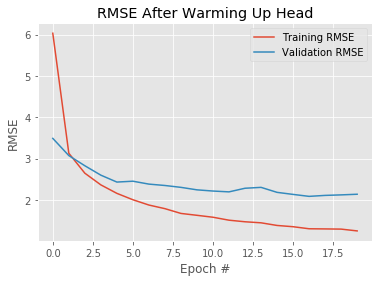

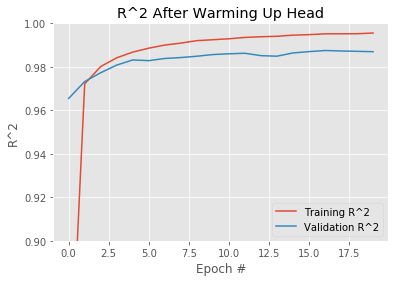

In [53]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [54]:
# predict from model
predictions = model.predict(X_val_vgg, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_vgg*48+48))**2)))**0.5))

RMSE of Predictions:    2.148182024938312


In [55]:
# After warming up the head FC layers, unfreeze the final set of CONV layers
# to train them
for layer in baseModel.layers[15:]:
    layer.trainable=True

In [56]:
# Recompile our model to train some of the CONV layers
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train model again to fine-tune both the final few CONV layers along with the head
# of FC layers
%time H = model.fit(X_train_vgg, y_train_vgg, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_vgg, y_val_vgg), verbose=2)

Train on 3424 samples, validate on 428 samples
Epoch 1/20
 - 11s - loss: 0.0841 - rmse: 0.0841 - rmse_96: 4.0353 - r_squared: 0.8589 - val_loss: 0.0549 - val_rmse: 0.0549 - val_rmse_96: 2.6373 - val_r_squared: 0.9801
Epoch 2/20
 - 11s - loss: 0.0477 - rmse: 0.0477 - rmse_96: 2.2912 - r_squared: 0.9849 - val_loss: 0.0401 - val_rmse: 0.0401 - val_rmse_96: 1.9259 - val_r_squared: 0.9894
Epoch 3/20
 - 11s - loss: 0.0370 - rmse: 0.0370 - rmse_96: 1.7762 - r_squared: 0.9910 - val_loss: 0.0358 - val_rmse: 0.0358 - val_rmse_96: 1.7171 - val_r_squared: 0.9915
Epoch 4/20
 - 11s - loss: 0.0321 - rmse: 0.0321 - rmse_96: 1.5392 - r_squared: 0.9933 - val_loss: 0.0351 - val_rmse: 0.0351 - val_rmse_96: 1.6852 - val_r_squared: 0.9918
Epoch 5/20
 - 11s - loss: 0.0286 - rmse: 0.0286 - rmse_96: 1.3731 - r_squared: 0.9947 - val_loss: 0.0324 - val_rmse: 0.0324 - val_rmse_96: 1.5529 - val_r_squared: 0.9930
Epoch 6/20
 - 11s - loss: 0.0257 - rmse: 0.0257 - rmse_96: 1.2344 - r_squared: 0.9957 - val_loss: 0.030

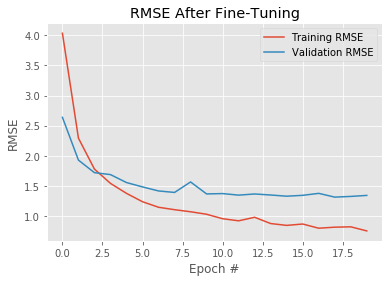

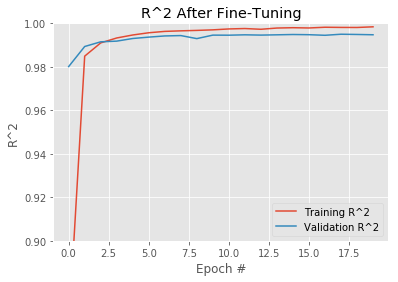

In [57]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [58]:
# predict from model
predictions = model.predict(X_val_vgg, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_vgg*48+48))**2)))**0.5))

RMSE of Predictions:    1.363888056241826


# Transfer Learning - VGG16 Fine Tuning

##  Only observations with complete labels

## Early stopping on epochs specification & data augmentation (10 degree rotation & histogram equalization)

In [59]:
# preprocessing data similar to pre-trained VGG model
X_train_scale = training_1Darray - training_1Darray.mean()
X_val_scale = validation_1Darray - validation_1Darray.mean()

In [60]:
X_train_scale, X_val_scale = np.vstack(X_train_scale), np.vstack(X_val_scale)
X_train_scale, X_val_scale = X_train_scale.astype(np.float32), X_val_scale.astype(np.float32)
X_train_scale, X_val_scale = X_train_scale.reshape(-1, 96, 96, 1), X_val_scale.reshape(-1, 96, 96, 1)
print(X_train_scale[0].shape, X_val_scale[0].shape)

(96, 96, 1) (96, 96, 1)


### Histogram Equalization

In [61]:
# Make copies of the training dataset to apply augmentation
# We will apply augmentation on the copy and combine with original
# dataset to increase dataset size
X_train_hist = X_train_scale.copy()

def hist_equal(im):
    img = im.reshape(96, 96)
    img_aug = exposure.equalize_hist(img)
    return img_aug

for img in range(0, len(X_train_hist)):
    X_train_hist[img] = hist_equal(X_train_hist[img]).reshape(96, 96, 1)

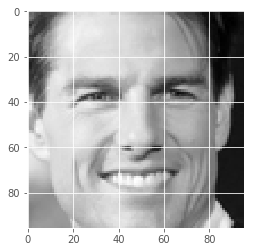

In [62]:
# QC - Original Image
plt.imshow(X_train_scale[1].reshape(96, 96), cmap='gray')

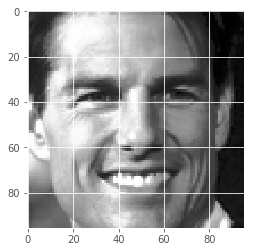

In [63]:
# QC - Image After Histogram Equalization
plt.imshow(X_train_hist[1].reshape(96, 96), cmap='gray')

### Rotate 10 degrees

In [64]:
def rotate_X(input_X, degree):
    
    # create an array of the same size
    output_X = np.zeros((input_X.shape), dtype=np.float64)
    
    # for each image, use sklearn's rotate function to rotate image
    # this somehow changes pixel values, cap value between 0 and 1
    for i in range(output_X.shape[0]):
        output_X[i] = np.clip(rotate(input_X[i], degree, reshape=False, mode='constant'), 0, 1)
    return output_X

In [65]:
def rotate_y(input_y, degree, n_point):
    
    # create an array of the same size
    output_y = np.zeros((input_y.shape), dtype=np.float64)
    
    # define rotation angle and center of rotation
    theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2
    
    for i in range(output_y.shape[0]):
        
        # obtain x and y coordinates from dataset
        x = input_y.values[i][np.arange(0, n_point-1, 2)] * 48 + 48
        y = input_y.values[i][np.arange(1, n_point, 2)] * 48 + 48
        
        # use rotation matrix to rotate coordinates around center
        x2 = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        y2 = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        x2 = (x2 - 48) / 48
        y2 = (y2 - 48) / 48
        
        # put x and y back in original shape
        output_y[i] = np.vstack((x2, y2)).transpose().flatten()
        
    return output_y

In [66]:
X_train_rotate = X_train_scale.copy()
X_train_rotate = rotate_X(X_train_rotate, 10)

In [67]:
y_train_rotate = rotate_y(y_train, 10, 30)

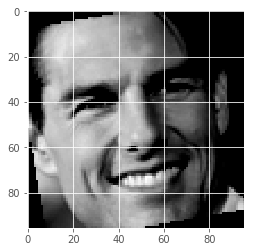

In [68]:
plt.imshow(X_train_rotate[1].reshape(96, 96), cmap='gray')

### Combine datasets

In [69]:
# Combine datasets
X_train_combined = np.concatenate((X_train_scale, X_train_hist), axis=0)
y_train_combined = np.concatenate((y_train, y_train), axis=0)

X_train_combined2 = np.concatenate((X_train_combined, X_train_rotate), axis=0)
y_train_combined2 = np.concatenate((y_train_combined, y_train_rotate), axis=0)

In [70]:
# mimic 3 channels
X_train_vgg, X_val_vgg = np.tile(X_train_combined2[:, :, :], [1, 1, 3]), np.tile(X_val_scale[:, :, :], [1, 1, 3])
print(X_train_vgg[0].shape, X_val_vgg[0].shape)

(96, 96, 3) (96, 96, 3)


### Drop Missing Values

In [71]:
# Drop missing values again
X_train_vgg = X_train_vgg[~np.isnan(y_train_combined2).any(axis=1)]
y_train_vgg = y_train_combined2[~np.isnan(y_train_combined2).any(axis=1)]

X_val_vgg = X_val_vgg[~np.isnan(y_val).any(axis=1)]
y_val_vgg = y_val[~np.isnan(y_val).any(axis=1)]

print(X_train_vgg.shape, y_train_vgg.shape)
print(X_val_vgg.shape, y_val_vgg.shape)

(5136, 96, 96, 3) (5136, 30)
(428, 96, 96, 3) (428, 30)


### Shuffle Data

In [72]:
# Shuffle data so augmented data aren't all together
np.random.seed(666)
shuffle = np.random.permutation(len(X_train_vgg))
X_train_vgg = X_train_vgg[shuffle]
y_train_vgg = y_train_vgg[shuffle]

### Transfer Learning Model

In [73]:
# Load VGG16 network trained on ImageNet without head FC layers
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Initialize a new head consisting of FC layers to replace VGG16's head
headModel = FCHeadNet.build(baseModel)

# Create Frankenstein (attach new FC head to VGG16 body)
model = Model(inputs=baseModel.input, outputs=headModel)

In [74]:
# Loop over layers from VGG model and freeze them so they don't go through
# backpropagation
for layer in baseModel.layers:
    layer.trainable = False

In [75]:
# Compile our model
# Run a few epochs to warm up our new head (FC layers)
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train head of network for a few epochs allowing new FC layers to start to
# become initialized with actual "learned" values versus purely random values
%time H = model.fit(X_train_vgg, y_train_vgg, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_vgg, y_val_vgg), verbose=2)

Train on 5136 samples, validate on 428 samples
Epoch 1/20
 - 12s - loss: 0.1076 - rmse: 0.1076 - rmse_96: 5.1632 - r_squared: 0.8697 - val_loss: 0.0723 - val_rmse: 0.0723 - val_rmse_96: 3.4691 - val_r_squared: 0.9659
Epoch 2/20
 - 12s - loss: 0.0632 - rmse: 0.0632 - rmse_96: 3.0326 - r_squared: 0.9739 - val_loss: 0.0599 - val_rmse: 0.0599 - val_rmse_96: 2.8772 - val_r_squared: 0.9765
Epoch 3/20
 - 12s - loss: 0.0549 - rmse: 0.0549 - rmse_96: 2.6346 - r_squared: 0.9803 - val_loss: 0.0542 - val_rmse: 0.0542 - val_rmse_96: 2.6027 - val_r_squared: 0.9808
Epoch 4/20
 - 12s - loss: 0.0498 - rmse: 0.0498 - rmse_96: 2.3914 - r_squared: 0.9837 - val_loss: 0.0515 - val_rmse: 0.0515 - val_rmse_96: 2.4733 - val_r_squared: 0.9826
Epoch 5/20
 - 12s - loss: 0.0458 - rmse: 0.0458 - rmse_96: 2.1997 - r_squared: 0.9863 - val_loss: 0.0520 - val_rmse: 0.0520 - val_rmse_96: 2.4958 - val_r_squared: 0.9823
Epoch 6/20
 - 12s - loss: 0.0432 - rmse: 0.0432 - rmse_96: 2.0751 - r_squared: 0.9878 - val_loss: 0.051

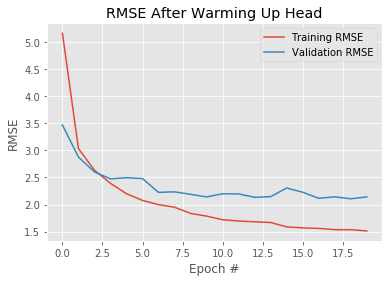

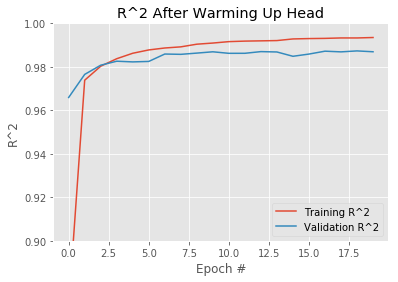

In [76]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [77]:
# predict from model
predictions = model.predict(X_val_vgg, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_vgg*48+48))**2)))**0.5))

RMSE of Predictions:    2.1508945910502173


In [78]:
# After warming up the head FC layers, unfreeze the final set of CONV layers
# to train them
for layer in baseModel.layers[15:]:
    layer.trainable=True

In [79]:
# Recompile our model to train some of the CONV layers
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train model again to fine-tune both the final few CONV layers along with the head
# of FC layers
%time H = model.fit(X_train_vgg, y_train_vgg, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_vgg, y_val_vgg), verbose=2)

Train on 5136 samples, validate on 428 samples
Epoch 1/20
 - 16s - loss: 0.0708 - rmse: 0.0708 - rmse_96: 3.3976 - r_squared: 0.9561 - val_loss: 0.0442 - val_rmse: 0.0442 - val_rmse_96: 2.1199 - val_r_squared: 0.9872
Epoch 2/20
 - 16s - loss: 0.0440 - rmse: 0.0440 - rmse_96: 2.1097 - r_squared: 0.9873 - val_loss: 0.0375 - val_rmse: 0.0375 - val_rmse_96: 1.8019 - val_r_squared: 0.9907
Epoch 3/20
 - 16s - loss: 0.0376 - rmse: 0.0376 - rmse_96: 1.8064 - r_squared: 0.9907 - val_loss: 0.0350 - val_rmse: 0.0350 - val_rmse_96: 1.6783 - val_r_squared: 0.9919
Epoch 4/20
 - 16s - loss: 0.0336 - rmse: 0.0336 - rmse_96: 1.6120 - r_squared: 0.9926 - val_loss: 0.0313 - val_rmse: 0.0313 - val_rmse_96: 1.5041 - val_r_squared: 0.9934
Epoch 5/20
 - 16s - loss: 0.0311 - rmse: 0.0311 - rmse_96: 1.4927 - r_squared: 0.9937 - val_loss: 0.0326 - val_rmse: 0.0326 - val_rmse_96: 1.5655 - val_r_squared: 0.9929
Epoch 6/20
 - 16s - loss: 0.0288 - rmse: 0.0288 - rmse_96: 1.3816 - r_squared: 0.9946 - val_loss: 0.030

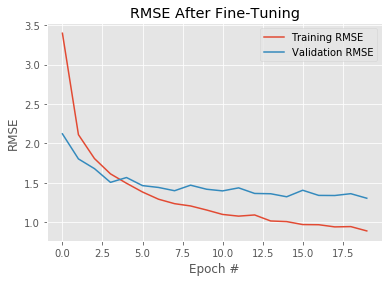

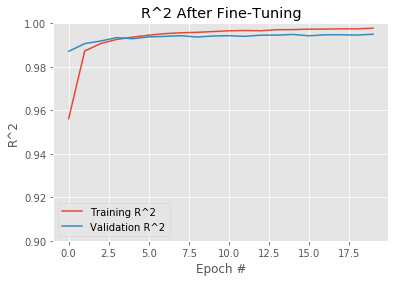

In [80]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [81]:
# predict from model
predictions = model.predict(X_val_vgg, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_vgg*48+48))**2)))**0.5))

RMSE of Predictions:    1.3334578316897214


# Transfer Learning - VGG16 Fine Tuning

##  Two Models to use all observations

## Early stopping on epochs specification & Data Augmentation (Histogram Equalization & 10 Degree Rotation)

In [82]:
# preprocessing data similar to pre-trained VGG model
X_train_scale = training_1Darray - training_1Darray.mean()
X_val_scale = validation_1Darray - validation_1Darray.mean()

In [83]:
X_train_scale, X_val_scale = np.vstack(X_train_scale), np.vstack(X_val_scale)
X_train_scale, X_val_scale = X_train_scale.astype(np.float32), X_val_scale.astype(np.float32)
X_train_scale, X_val_scale = X_train_scale.reshape(-1, 96, 96, 1), X_val_scale.reshape(-1, 96, 96, 1)
print(X_train_scale[0].shape, X_val_scale[0].shape)

(96, 96, 1) (96, 96, 1)


### Histogram Equalization

In [84]:
# Make copies of the training dataset to apply augmentation
# We will apply augmentation on the copy and combine with original
# dataset to increase dataset size
X_train_hist = X_train_scale.copy()

def hist_equal(im):
    img = im.reshape(96, 96)
    img_aug = exposure.equalize_hist(img)
    return img_aug

for img in range(0, len(X_train_hist)):
    X_train_hist[img] = hist_equal(X_train_hist[img]).reshape(96, 96, 1)

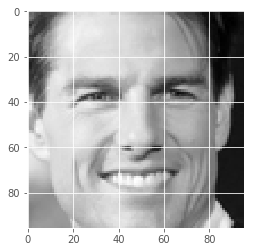

In [85]:
# QC - Original Image
plt.imshow(X_train_scale[1].reshape(96, 96), cmap='gray')

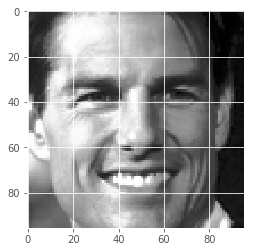

In [86]:
# QC - Image After Histogram Equalization
plt.imshow(X_train_hist[1].reshape(96, 96), cmap='gray')

### Rotate 10 degrees

In [87]:
def rotate_X(input_X, degree):
    
    # create an array of the same size
    output_X = np.zeros((input_X.shape), dtype=np.float64)
    
    # for each image, use sklearn's rotate function to rotate image
    # this somehow changes pixel values, cap value between 0 and 1
    for i in range(output_X.shape[0]):
        output_X[i] = np.clip(rotate(input_X[i], degree, reshape=False, mode='constant'), 0, 1)
    return output_X

In [88]:
def rotate_y(input_y, degree, n_point):
    
    # create an array of the same size
    output_y = np.zeros((input_y.shape), dtype=np.float64)
    
    # define rotation angle and center of rotation
    theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2
    
    for i in range(output_y.shape[0]):
        
        # obtain x and y coordinates from dataset
        x = input_y.values[i][np.arange(0, n_point-1, 2)] * 48 + 48
        y = input_y.values[i][np.arange(1, n_point, 2)] * 48 + 48
        
        # use rotation matrix to rotate coordinates around center
        x2 = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        y2 = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        x2 = (x2 - 48) / 48
        y2 = (y2 - 48) / 48
        
        # put x and y back in original shape
        output_y[i] = np.vstack((x2, y2)).transpose().flatten()
        
    return output_y

In [89]:
X_train_rotate = X_train_scale.copy()
X_train_rotate = rotate_X(X_train_rotate, 10)

In [90]:
y_train_rotate = rotate_y(y_train, 10, 30)

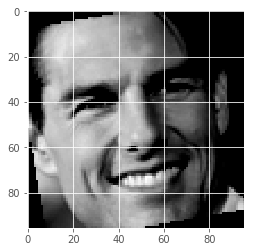

In [91]:
plt.imshow(X_train_rotate[1].reshape(96, 96), cmap='gray')

### Combine datasets

In [92]:
# Combine datasets
X_train_combined = np.concatenate((X_train_scale, X_train_hist), axis=0)
y_train_combined = np.concatenate((y_train, y_train), axis=0)

X_train_combined2 = np.concatenate((X_train_combined, X_train_rotate), axis=0)
y_train_combined2 = np.concatenate((y_train_combined, y_train_rotate), axis=0)

In [93]:
# mimic 3 channels
X_train_vgg, X_val_vgg = np.tile(X_train_combined2[:, :, :], [1, 1, 3]), np.tile(X_val_scale[:, :, :], [1, 1, 3])
print(X_train_vgg[0].shape, X_val_vgg[0].shape)

(96, 96, 3) (96, 96, 3)


### Shuffle Data

In [94]:
# Shuffle data so augmented data aren't all together
np.random.seed(666)
shuffle = np.random.permutation(len(X_train_vgg))
X_train_vgg = X_train_vgg[shuffle]
y_train_vgg = y_train_combined2[shuffle]

## Model 1 (4 keypoints)

In [99]:
# model with specific points
points = [0, 1, 2, 3, 20, 21, 28, 29]
y_train_model1 = y_train_vgg[:, points]
y_val_model1 = y_val.values[:, points]

In [100]:
# get index of non-missing labels
index_train = ~np.isnan(y_train_model1).any(axis=1)
index_val = ~np.isnan(y_val_model1).any(axis=1)

In [101]:
# filter out missing labels on training and validation data
X_train_model1 = X_train_vgg[index_train]
y_train_model1 = y_train_model1[index_train]

X_val_model1 = X_val_vgg[index_val]
y_val_model1 = y_val_model1[index_val]

### Transfer Learning Model

In [102]:
class FCHeadNet:
    @staticmethod
    def build(baseModel):
        np.random.seed(666)
        # Initialize head model from pre-trained model output
        # This is basically adapted from our baseline_CNN
        # Just with an extra layer
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(256, activation="relu")(headModel)
        #headModel = PReLU()(headModel)
        headModel = Dense(8, activation="linear")(headModel)
        
        return headModel        

In [103]:
# Load VGG16 network trained on ImageNet without head FC layers
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Initialize a new head consisting of FC layers to replace VGG16's head
headModel = FCHeadNet.build(baseModel)

# Create Frankenstein (attach new FC head to VGG16 body)
model = Model(inputs=baseModel.input, outputs=headModel)

In [104]:
# Loop over layers from VGG model and freeze them so they don't go through
# backpropagation
for layer in baseModel.layers:
    layer.trainable = False

In [105]:
# Compile our model
# Run a few epochs to warm up our new head (FC layers)
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train head of network for a few epochs allowing new FC layers to start to
# become initialized with actual "learned" values versus purely random values
%time H = model.fit(X_train_model1, y_train_model1, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_model1, y_val_model1), verbose=2)

Train on 5136 samples, validate on 428 samples
Epoch 1/20
 - 12s - loss: 0.1328 - rmse: 0.1328 - rmse_96: 6.3732 - r_squared: 0.7232 - val_loss: 0.0699 - val_rmse: 0.0699 - val_rmse_96: 3.3534 - val_r_squared: 0.9592
Epoch 2/20
 - 12s - loss: 0.0660 - rmse: 0.0660 - rmse_96: 3.1683 - r_squared: 0.9630 - val_loss: 0.0610 - val_rmse: 0.0610 - val_rmse_96: 2.9267 - val_r_squared: 0.9689
Epoch 3/20
 - 12s - loss: 0.0555 - rmse: 0.0555 - rmse_96: 2.6663 - r_squared: 0.9739 - val_loss: 0.0535 - val_rmse: 0.0535 - val_rmse_96: 2.5661 - val_r_squared: 0.9760
Epoch 4/20
 - 12s - loss: 0.0495 - rmse: 0.0495 - rmse_96: 2.3779 - r_squared: 0.9793 - val_loss: 0.0574 - val_rmse: 0.0574 - val_rmse_96: 2.7572 - val_r_squared: 0.9723
Epoch 5/20
 - 12s - loss: 0.0446 - rmse: 0.0446 - rmse_96: 2.1394 - r_squared: 0.9833 - val_loss: 0.0489 - val_rmse: 0.0489 - val_rmse_96: 2.3465 - val_r_squared: 0.9799
Epoch 6/20
 - 12s - loss: 0.0422 - rmse: 0.0422 - rmse_96: 2.0242 - r_squared: 0.9850 - val_loss: 0.046

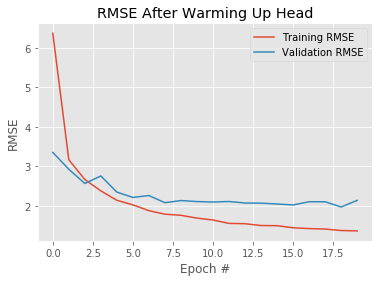

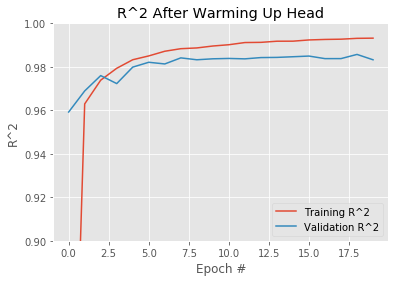

In [106]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [109]:
# predict from model
predictions = model.predict(X_val_model1, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_model1*48+48))**2)))**0.5))

RMSE of Predictions:    2.152456844840934


In [110]:
# After warming up the head FC layers, unfreeze the final set of CONV layers
# to train them
for layer in baseModel.layers[15:]:
    layer.trainable=True

In [111]:
# Recompile our model to train some of the CONV layers
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train model again to fine-tune both the final few CONV layers along with the head
# of FC layers
%time H = model.fit(X_train_model1, y_train_model1, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_model1, y_val_model1), verbose=2)

Train on 5136 samples, validate on 428 samples
Epoch 1/20
 - 16s - loss: 0.0792 - rmse: 0.0792 - rmse_96: 3.8010 - r_squared: 0.8963 - val_loss: 0.0440 - val_rmse: 0.0440 - val_rmse_96: 2.1120 - val_r_squared: 0.9835
Epoch 2/20
 - 15s - loss: 0.0423 - rmse: 0.0423 - rmse_96: 2.0312 - r_squared: 0.9849 - val_loss: 0.0382 - val_rmse: 0.0382 - val_rmse_96: 1.8342 - val_r_squared: 0.9875
Epoch 3/20
 - 16s - loss: 0.0356 - rmse: 0.0356 - rmse_96: 1.7087 - r_squared: 0.9893 - val_loss: 0.0312 - val_rmse: 0.0312 - val_rmse_96: 1.4971 - val_r_squared: 0.9916
Epoch 4/20
 - 16s - loss: 0.0308 - rmse: 0.0308 - rmse_96: 1.4775 - r_squared: 0.9920 - val_loss: 0.0300 - val_rmse: 0.0300 - val_rmse_96: 1.4387 - val_r_squared: 0.9922
Epoch 5/20
 - 16s - loss: 0.0279 - rmse: 0.0279 - rmse_96: 1.3404 - r_squared: 0.9934 - val_loss: 0.0334 - val_rmse: 0.0334 - val_rmse_96: 1.6038 - val_r_squared: 0.9905
Epoch 6/20
 - 16s - loss: 0.0258 - rmse: 0.0258 - rmse_96: 1.2377 - r_squared: 0.9944 - val_loss: 0.030

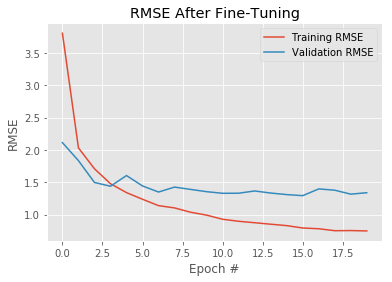

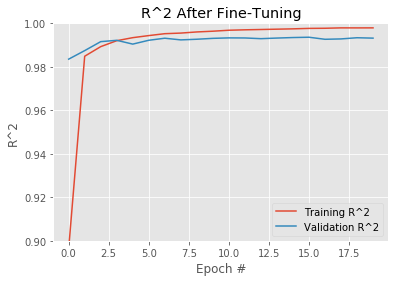

In [112]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [113]:
# predict from model
predictions = model.predict(X_val_model1, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_model1*48+48))**2)))**0.5))

RMSE of Predictions:    1.372658252660325


## Model 2 (11 keypoints)

In [116]:
# model with specific points
points = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27]
y_train_model2 = y_train_vgg[:, points]
y_val_model2 = y_val.values[:, points]

In [117]:
# get index of non-missing labels
index_train = ~np.isnan(y_train_model2).any(axis=1)
index_val = ~np.isnan(y_val_model2).any(axis=1)

In [118]:
# filter out missing labels on training and validation data
X_train_model2 = X_train_vgg[index_train]
y_train_model2 = y_train_model2[index_train]

X_val_model2 = X_val_vgg[index_val]
y_val_model2 = y_val_model2[index_val]

### Transfer Learning Model

In [119]:
class FCHeadNet:
    @staticmethod
    def build(baseModel):
        np.random.seed(666)
        # Initialize head model from pre-trained model output
        # This is basically adapted from our baseline_CNN
        # Just with an extra layer
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(256, activation="relu")(headModel)
        #headModel = PReLU()(headModel)
        headModel = Dense(22, activation="linear")(headModel)
        
        return headModel        

In [120]:
# Load VGG16 network trained on ImageNet without head FC layers
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Initialize a new head consisting of FC layers to replace VGG16's head
headModel = FCHeadNet.build(baseModel)

# Create Frankenstein (attach new FC head to VGG16 body)
model = Model(inputs=baseModel.input, outputs=headModel)

In [121]:
# Loop over layers from VGG model and freeze them so they don't go through
# backpropagation
for layer in baseModel.layers:
    layer.trainable = False

In [122]:
# Compile our model
# Run a few epochs to warm up our new head (FC layers)
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train head of network for a few epochs allowing new FC layers to start to
# become initialized with actual "learned" values versus purely random values
%time H = model.fit(X_train_model2, y_train_model2, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_model2, y_val_model2), verbose=2)

Train on 5136 samples, validate on 428 samples
Epoch 1/20
 - 12s - loss: 0.1097 - rmse: 0.1097 - rmse_96: 5.2654 - r_squared: 0.8825 - val_loss: 0.0674 - val_rmse: 0.0674 - val_rmse_96: 3.2365 - val_r_squared: 0.9721
Epoch 2/20
 - 12s - loss: 0.0623 - rmse: 0.0623 - rmse_96: 2.9898 - r_squared: 0.9762 - val_loss: 0.0621 - val_rmse: 0.0621 - val_rmse_96: 2.9809 - val_r_squared: 0.9763
Epoch 3/20
 - 12s - loss: 0.0533 - rmse: 0.0533 - rmse_96: 2.5591 - r_squared: 0.9825 - val_loss: 0.0529 - val_rmse: 0.0529 - val_rmse_96: 2.5397 - val_r_squared: 0.9828
Epoch 4/20
 - 12s - loss: 0.0490 - rmse: 0.0490 - rmse_96: 2.3543 - r_squared: 0.9852 - val_loss: 0.0522 - val_rmse: 0.0522 - val_rmse_96: 2.5067 - val_r_squared: 0.9833
Epoch 5/20
 - 12s - loss: 0.0457 - rmse: 0.0457 - rmse_96: 2.1955 - r_squared: 0.9871 - val_loss: 0.0491 - val_rmse: 0.0491 - val_rmse_96: 2.3567 - val_r_squared: 0.9852
Epoch 6/20
 - 12s - loss: 0.0436 - rmse: 0.0436 - rmse_96: 2.0925 - r_squared: 0.9883 - val_loss: 0.048

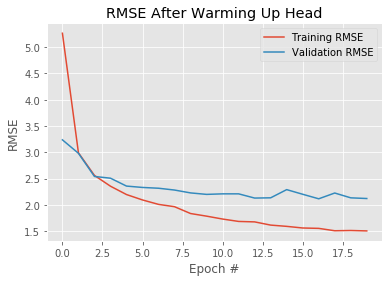

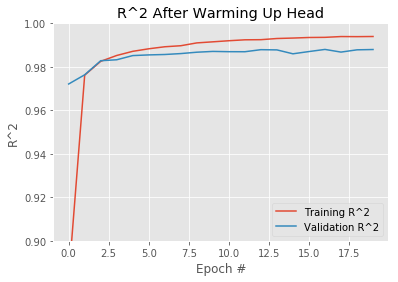

In [123]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [124]:
# predict from model
predictions = model.predict(X_val_model2, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_model2*48+48))**2)))**0.5))

RMSE of Predictions:    2.131627127206383


In [125]:
# After warming up the head FC layers, unfreeze the final set of CONV layers
# to train them
for layer in baseModel.layers[15:]:
    layer.trainable=True

In [126]:
# Recompile our model to train some of the CONV layers
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train model again to fine-tune both the final few CONV layers along with the head
# of FC layers
%time H = model.fit(X_train_model2, y_train_model2, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_model2, y_val_model2), verbose=2)

Train on 5136 samples, validate on 428 samples
Epoch 1/20
 - 17s - loss: 0.0751 - rmse: 0.0751 - rmse_96: 3.6059 - r_squared: 0.9481 - val_loss: 0.0482 - val_rmse: 0.0482 - val_rmse_96: 2.3123 - val_r_squared: 0.9857
Epoch 2/20
 - 16s - loss: 0.0471 - rmse: 0.0471 - rmse_96: 2.2610 - r_squared: 0.9863 - val_loss: 0.0387 - val_rmse: 0.0387 - val_rmse_96: 1.8585 - val_r_squared: 0.9907
Epoch 3/20
 - 16s - loss: 0.0399 - rmse: 0.0399 - rmse_96: 1.9172 - r_squared: 0.9902 - val_loss: 0.0383 - val_rmse: 0.0383 - val_rmse_96: 1.8369 - val_r_squared: 0.9909
Epoch 4/20
 - 16s - loss: 0.0362 - rmse: 0.0362 - rmse_96: 1.7361 - r_squared: 0.9919 - val_loss: 0.0345 - val_rmse: 0.0345 - val_rmse_96: 1.6569 - val_r_squared: 0.9926
Epoch 5/20
 - 16s - loss: 0.0325 - rmse: 0.0325 - rmse_96: 1.5617 - r_squared: 0.9935 - val_loss: 0.0314 - val_rmse: 0.0314 - val_rmse_96: 1.5094 - val_r_squared: 0.9938
Epoch 6/20
 - 16s - loss: 0.0302 - rmse: 0.0302 - rmse_96: 1.4497 - r_squared: 0.9944 - val_loss: 0.030

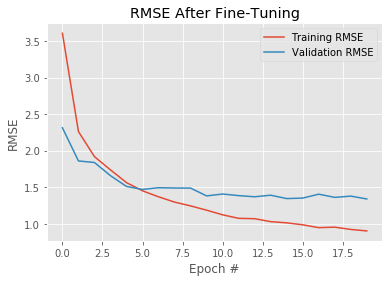

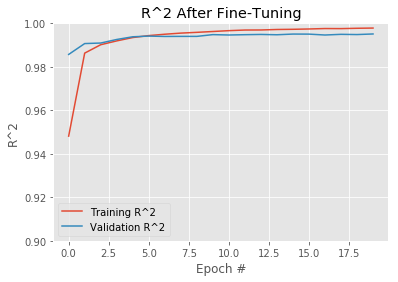

In [127]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [128]:
# predict from model
predictions = model.predict(X_val_model2, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_model2*48+48))**2)))**0.5))

RMSE of Predictions:    1.3581892520260763


# Transfer Learning - Xception Fine Tuning

##  Two Models to use all observations

## Early stopping on epochs specification & Data Augmentation (Histogram Equalization & 10 degree rotation)

In [129]:
# preprocessing data similar to pre-trained VGG model
X_train_scale = training_1Darray - training_1Darray.mean()
X_val_scale = validation_1Darray - validation_1Darray.mean()

In [130]:
X_train_scale, X_val_scale = np.vstack(X_train_scale), np.vstack(X_val_scale)
X_train_scale, X_val_scale = X_train_scale.astype(np.float32), X_val_scale.astype(np.float32)
X_train_scale, X_val_scale = X_train_scale.reshape(-1, 96, 96, 1), X_val_scale.reshape(-1, 96, 96, 1)
print(X_train_scale[0].shape, X_val_scale[0].shape)

(96, 96, 1) (96, 96, 1)


### Histogram Equalization

In [131]:
# Make copies of the training dataset to apply augmentation
# We will apply augmentation on the copy and combine with original
# dataset to increase dataset size
X_train_hist = X_train_scale.copy()

def hist_equal(im):
    img = im.reshape(96, 96)
    img_aug = exposure.equalize_hist(img)
    return img_aug

for img in range(0, len(X_train_hist)):
    X_train_hist[img] = hist_equal(X_train_hist[img]).reshape(96, 96, 1)

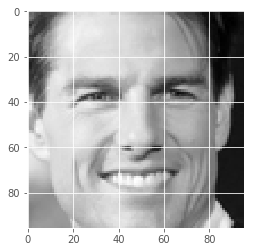

In [132]:
# QC - Original Image
plt.imshow(X_train_scale[1].reshape(96, 96), cmap='gray')

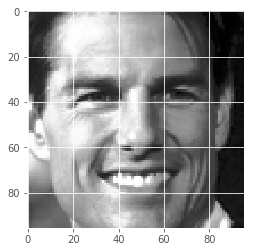

In [133]:
# QC - Image After Histogram Equalization
plt.imshow(X_train_hist[1].reshape(96, 96), cmap='gray')

### Rotate 10 degrees

In [134]:
def rotate_X(input_X, degree):
    
    # create an array of the same size
    output_X = np.zeros((input_X.shape), dtype=np.float64)
    
    # for each image, use sklearn's rotate function to rotate image
    # this somehow changes pixel values, cap value between 0 and 1
    for i in range(output_X.shape[0]):
        output_X[i] = np.clip(rotate(input_X[i], degree, reshape=False, mode='constant'), 0, 1)
    return output_X

In [135]:
def rotate_y(input_y, degree, n_point):
    
    # create an array of the same size
    output_y = np.zeros((input_y.shape), dtype=np.float64)
    
    # define rotation angle and center of rotation
    theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2
    
    for i in range(output_y.shape[0]):
        
        # obtain x and y coordinates from dataset
        x = input_y.values[i][np.arange(0, n_point-1, 2)] * 48 + 48
        y = input_y.values[i][np.arange(1, n_point, 2)] * 48 + 48
        
        # use rotation matrix to rotate coordinates around center
        x2 = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        y2 = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        x2 = (x2 - 48) / 48
        y2 = (y2 - 48) / 48
        
        # put x and y back in original shape
        output_y[i] = np.vstack((x2, y2)).transpose().flatten()
        
    return output_y

In [136]:
X_train_rotate = X_train_scale.copy()
X_train_rotate = rotate_X(X_train_rotate, 10)

In [137]:
y_train_rotate = rotate_y(y_train, 10, 30)

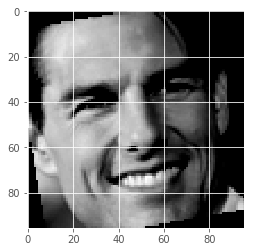

In [138]:
plt.imshow(X_train_rotate[1].reshape(96, 96), cmap='gray')

### Combine datasets

In [139]:
# Combine datasets
X_train_combined = np.concatenate((X_train_scale, X_train_hist), axis=0)
y_train_combined = np.concatenate((y_train, y_train), axis=0)

X_train_combined2 = np.concatenate((X_train_combined, X_train_rotate), axis=0)
y_train_combined2 = np.concatenate((y_train_combined, y_train_rotate), axis=0)

In [140]:
# mimic 3 channels
X_train_xcept, X_val_xcept = np.tile(X_train_combined2[:, :, :], [1, 1, 3]), np.tile(X_val_scale[:, :, :], [1, 1, 3])
print(X_train_xcept[0].shape, X_val_xcept[0].shape)

(96, 96, 3) (96, 96, 3)


### Shuffle Data

In [141]:
# Shuffle data so augmented data aren't all together
np.random.seed(666)
shuffle = np.random.permutation(len(X_train_vgg))
X_train_xcept = X_train_xcept[shuffle]
y_train_xcept = y_train_combined2[shuffle]

## Model 1 (4 keypoints)

In [142]:
# model with specific points
points = [0, 1, 2, 3, 20, 21, 28, 29]
y_train_model1 = y_train_xcept[:, points]
y_val_model1 = y_val.values[:, points]

In [143]:
# get index of non-missing labels
index_train = ~np.isnan(y_train_model1).any(axis=1)
index_val = ~np.isnan(y_val_model1).any(axis=1)

In [144]:
# filter out missing labels on training and validation data
X_train_model1 = X_train_xcept[index_train]
y_train_model1 = y_train_model1[index_train]

X_val_model1 = X_val_xcept[index_val]
y_val_model1 = y_val_model1[index_val]

### Transfer Learning Model

In [145]:
class FCHeadNet:
    @staticmethod
    def build(baseModel):
        np.random.seed(666)
        # Initialize head model from pre-trained model output
        # This is basically adapted from our baseline_CNN
        # Just with an extra layer
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(256, activation="relu")(headModel)
        #headModel = PReLU()(headModel)
        headModel = Dense(8, activation="linear")(headModel)
        
        return headModel        

In [148]:
# Load Xception network trained on ImageNet without head FC layers
baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Initialize a new head consisting of FC layers to replace Xception's head
headModel = FCHeadNet.build(baseModel)

# Create Frankenstein (attach new FC head to Xception body)
model = Model(inputs=baseModel.input, outputs=headModel)

83689472/83683744 [==============================] - 5s 0us/step


In [149]:
# Loop over layers from Xception model and freeze them so they don't go through
# backpropagation
for layer in baseModel.layers:
    layer.trainable = False

In [150]:
# Compile our model
# Run a few epochs to warm up our new head (FC layers)
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train head of network for a few epochs allowing new FC layers to start to
# become initialized with actual "learned" values versus purely random values
%time H = model.fit(X_train_model1, y_train_model1, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_model1, y_val_model1), verbose=2)

Train on 5136 samples, validate on 428 samples
Epoch 1/20
 - 17s - loss: 0.2429 - rmse: 0.2429 - rmse_96: 11.6600 - r_squared: -8.1343e-01 - val_loss: 0.2499 - val_rmse: 0.2499 - val_rmse_96: 11.9966 - val_r_squared: 0.4805
Epoch 2/20
 - 14s - loss: 0.1068 - rmse: 0.1068 - rmse_96: 5.1287 - r_squared: 0.9034 - val_loss: 0.2128 - val_rmse: 0.2128 - val_rmse_96: 10.2130 - val_r_squared: 0.6234
Epoch 3/20
 - 14s - loss: 0.0901 - rmse: 0.0901 - rmse_96: 4.3249 - r_squared: 0.9318 - val_loss: 0.1573 - val_rmse: 0.1573 - val_rmse_96: 7.5501 - val_r_squared: 0.7940
Epoch 4/20
 - 14s - loss: 0.0784 - rmse: 0.0784 - rmse_96: 3.7620 - r_squared: 0.9485 - val_loss: 0.1649 - val_rmse: 0.1649 - val_rmse_96: 7.9130 - val_r_squared: 0.7739
Epoch 5/20
 - 14s - loss: 0.0718 - rmse: 0.0718 - rmse_96: 3.4472 - r_squared: 0.9567 - val_loss: 0.1342 - val_rmse: 0.1342 - val_rmse_96: 6.4397 - val_r_squared: 0.8502
Epoch 6/20
 - 14s - loss: 0.0678 - rmse: 0.0678 - rmse_96: 3.2564 - r_squared: 0.9614 - val_los

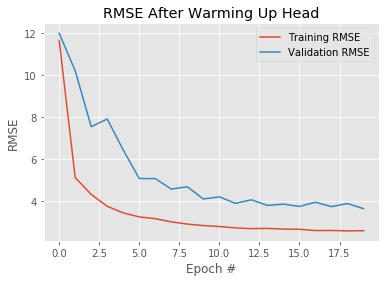

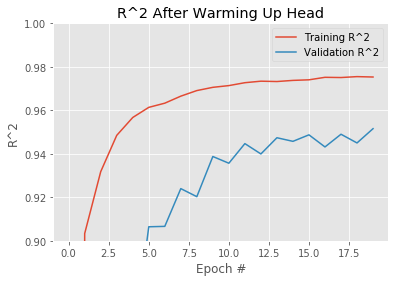

In [151]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [152]:
# predict from model
predictions = model.predict(X_val_model1, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_model1*48+48))**2)))**0.5))

RMSE of Predictions:    3.670123132828057


In [153]:
# After warming up the head FC layers, unfreeze the final set of CONV layers
# to train them
for layer in baseModel.layers[15:]:
    layer.trainable=True

In [154]:
# Recompile our model to train some of the CONV layers
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train model again to fine-tune both the final few CONV layers along with the head
# of FC layers
%time H = model.fit(X_train_model1, y_train_model1, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_model1, y_val_model1), verbose=2)

Train on 5136 samples, validate on 428 samples
Epoch 1/20
 - 50s - loss: 0.0557 - rmse: 0.0557 - rmse_96: 2.6753 - r_squared: 0.9735 - val_loss: 0.0509 - val_rmse: 0.0509 - val_rmse_96: 2.4455 - val_r_squared: 0.9782
Epoch 2/20
 - 41s - loss: 0.0432 - rmse: 0.0432 - rmse_96: 2.0732 - r_squared: 0.9843 - val_loss: 0.0408 - val_rmse: 0.0408 - val_rmse_96: 1.9566 - val_r_squared: 0.9860
Epoch 3/20
 - 41s - loss: 0.0388 - rmse: 0.0388 - rmse_96: 1.8600 - r_squared: 0.9874 - val_loss: 0.0407 - val_rmse: 0.0407 - val_rmse_96: 1.9534 - val_r_squared: 0.9860
Epoch 4/20
 - 41s - loss: 0.0343 - rmse: 0.0343 - rmse_96: 1.6479 - r_squared: 0.9900 - val_loss: 0.0386 - val_rmse: 0.0386 - val_rmse_96: 1.8504 - val_r_squared: 0.9874
Epoch 5/20
 - 41s - loss: 0.0314 - rmse: 0.0314 - rmse_96: 1.5089 - r_squared: 0.9917 - val_loss: 0.0323 - val_rmse: 0.0323 - val_rmse_96: 1.5526 - val_r_squared: 0.9910
Epoch 6/20
 - 41s - loss: 0.0282 - rmse: 0.0282 - rmse_96: 1.3550 - r_squared: 0.9933 - val_loss: 0.036

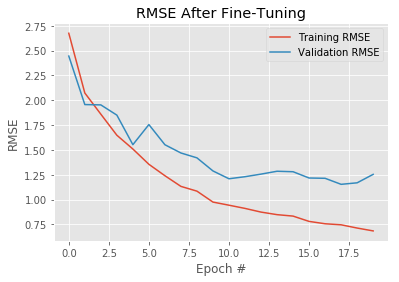

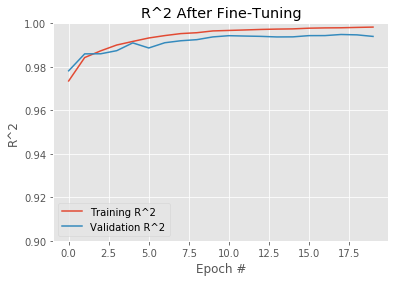

In [155]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [156]:
# predict from model
predictions = model.predict(X_val_model1, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_model1*48+48))**2)))**0.5))

RMSE of Predictions:    1.2916841146869866


## Model 2 (11 keypoints)

In [157]:
# model with specific points
points = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,22,23,24,25,26,27]
y_train_model2 = y_train_xcept[:, points]
y_val_model2 = y_val.values[:, points]

In [158]:
# get index of non-missing labels
index_train = ~np.isnan(y_train_model2).any(axis=1)
index_val = ~np.isnan(y_val_model2).any(axis=1)

In [159]:
# filter out missing labels on training and validation data
X_train_model2 = X_train_xcept[index_train]
y_train_model2 = y_train_model2[index_train]

X_val_model2 = X_val_xcept[index_val]
y_val_model2 = y_val_model2[index_val]

### Transfer Learning Model

In [160]:
class FCHeadNet:
    @staticmethod
    def build(baseModel):
        np.random.seed(666)
        # Initialize head model from pre-trained model output
        # This is basically adapted from our baseline_CNN
        # Just with an extra layer
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(256, activation="relu")(headModel)
        #headModel = PReLU()(headModel)
        headModel = Dense(22, activation="linear")(headModel)
        
        return headModel        

In [161]:
# Load Xception network trained on ImageNet without head FC layers
baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Initialize a new head consisting of FC layers to replace Xception's head
headModel = FCHeadNet.build(baseModel)

# Create Frankenstein (attach new FC head to Xception body)
model = Model(inputs=baseModel.input, outputs=headModel)

In [162]:
# Loop over layers from Xception model and freeze them so they don't go through
# backpropagation
for layer in baseModel.layers:
    layer.trainable = False

In [163]:
# Compile our model
# Run a few epochs to warm up our new head (FC layers)
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train head of network for a few epochs allowing new FC layers to start to
# become initialized with actual "learned" values versus purely random values
%time H = model.fit(X_train_model2, y_train_model2, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_model2, y_val_model2), verbose=2)

Train on 5136 samples, validate on 428 samples
Epoch 1/20
 - 18s - loss: 0.2464 - rmse: 0.2464 - rmse_96: 11.8274 - r_squared: 0.3122 - val_loss: 0.2979 - val_rmse: 0.2979 - val_rmse_96: 14.3005 - val_r_squared: 0.4582
Epoch 2/20
 - 14s - loss: 0.1202 - rmse: 0.1202 - rmse_96: 5.7716 - r_squared: 0.9097 - val_loss: 0.2500 - val_rmse: 0.2500 - val_rmse_96: 11.9981 - val_r_squared: 0.6186
Epoch 3/20
 - 14s - loss: 0.0966 - rmse: 0.0966 - rmse_96: 4.6390 - r_squared: 0.9424 - val_loss: 0.1802 - val_rmse: 0.1802 - val_rmse_96: 8.6482 - val_r_squared: 0.8018
Epoch 4/20
 - 14s - loss: 0.0823 - rmse: 0.0823 - rmse_96: 3.9489 - r_squared: 0.9584 - val_loss: 0.1864 - val_rmse: 0.1864 - val_rmse_96: 8.9461 - val_r_squared: 0.7880
Epoch 5/20
 - 14s - loss: 0.0752 - rmse: 0.0752 - rmse_96: 3.6103 - r_squared: 0.9652 - val_loss: 0.1622 - val_rmse: 0.1622 - val_rmse_96: 7.7835 - val_r_squared: 0.8396
Epoch 6/20
 - 14s - loss: 0.0708 - rmse: 0.0708 - rmse_96: 3.3975 - r_squared: 0.9691 - val_loss: 0.

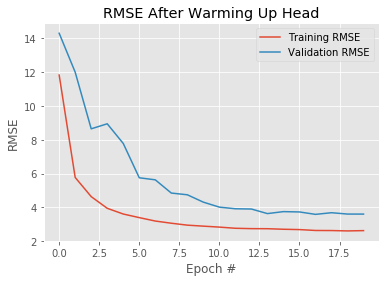

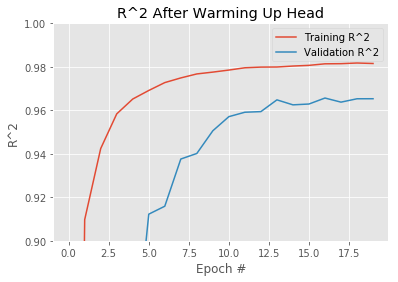

In [164]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [165]:
# predict from model
predictions = model.predict(X_val_model2, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_model2*48+48))**2)))**0.5))

RMSE of Predictions:    3.6227098004840173


In [166]:
# After warming up the head FC layers, unfreeze the final set of CONV layers
# to train them
for layer in baseModel.layers[15:]:
    layer.trainable=True

In [167]:
# Recompile our model to train some of the CONV layers
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train model again to fine-tune both the final few CONV layers along with the head
# of FC layers
%time H = model.fit(X_train_model2, y_train_model2, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_model2, y_val_model2), verbose=2)

Train on 5136 samples, validate on 428 samples
Epoch 1/20
 - 49s - loss: 0.0561 - rmse: 0.0561 - rmse_96: 2.6927 - r_squared: 0.9804 - val_loss: 0.0518 - val_rmse: 0.0518 - val_rmse_96: 2.4878 - val_r_squared: 0.9834
Epoch 2/20
 - 41s - loss: 0.0440 - rmse: 0.0440 - rmse_96: 2.1099 - r_squared: 0.9881 - val_loss: 0.0392 - val_rmse: 0.0392 - val_rmse_96: 1.8837 - val_r_squared: 0.9904
Epoch 3/20
 - 41s - loss: 0.0393 - rmse: 0.0393 - rmse_96: 1.8849 - r_squared: 0.9905 - val_loss: 0.0371 - val_rmse: 0.0371 - val_rmse_96: 1.7789 - val_r_squared: 0.9915
Epoch 4/20
 - 41s - loss: 0.0360 - rmse: 0.0360 - rmse_96: 1.7287 - r_squared: 0.9920 - val_loss: 0.0371 - val_rmse: 0.0371 - val_rmse_96: 1.7795 - val_r_squared: 0.9915
Epoch 5/20
 - 41s - loss: 0.0333 - rmse: 0.0333 - rmse_96: 1.5996 - r_squared: 0.9932 - val_loss: 0.0317 - val_rmse: 0.0317 - val_rmse_96: 1.5196 - val_r_squared: 0.9938
Epoch 6/20
 - 41s - loss: 0.0309 - rmse: 0.0309 - rmse_96: 1.4831 - r_squared: 0.9941 - val_loss: 0.032

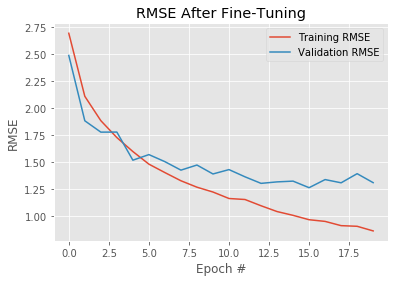

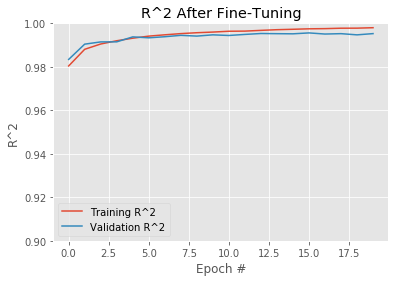

In [168]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [169]:
# predict from model
predictions = model.predict(X_val_model2, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_model2*48+48))**2)))**0.5))

RMSE of Predictions:    1.3359838109605984


# FAILURES

-------------------------------------------

# Transfer Learning - VGG16 Fine Tuning

##  Only observations with complete labels, no data augmentation

## Early stopping on epochs specification, batch normalization added to head

In [ ]:
class FCHeadNet_Batch:
    @staticmethod
    def build(baseModel):
        np.random.seed(666)
        # Initialize head model from pre-trained model output
        # This is basically adapted from our baseline_CNN
        # Just with an extra layer
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(256, activation="relu")(headModel)
        headModel = BatchNormalization()(headModel)
        headModel = Dense(30, activation="linear")(headModel)
        
        return headModel        

In [ ]:
# Load VGG16 network trained on ImageNet without head FC layers
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Initialize a new head consisting of FC layers to replace VGG16's head
headModel = FCHeadNet_Batch.build(baseModel)

# Create Frankenstein (attach new FC head to VGG16 body)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# Loop over layers from VGG model and freeze them so they don't go through
# backpropagation
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# Compile our model
# Run a few epochs to warm up our new head (FC layers)
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train head of network for a few epochs allowing new FC layers to start to
# become initialized with actual "learned" values versus purely random values
%time H = model.fit(X_train_vgg, y_train_vgg, epochs=25, shuffle=True, batch_size=32, validation_data=(X_val_vgg, y_val_vgg), verbose=2)

In [ ]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 25), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 25), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 25), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Warming Up Head")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [ ]:
# predict from model
predictions = model.predict(X_val_vgg, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_nm*48+48))**2)))**0.5))

In [ ]:
# After warming up the head FC layers, unfreeze the final set of CONV layers
# to train them
for layer in baseModel.layers[15:]:
    layer.trainable=True

In [ ]:
# Recompile our model to train some of the CONV layers
opt = Adam(lr=0.001)
model.compile(loss=rmse, optimizer=opt, metrics=[rmse, rmse_96, r_squared])

# Train model again to fine-tune both the final few CONV layers along with the head
# of FC layers
%time H = model.fit(X_train_vgg, y_train_vgg, epochs=20, shuffle=True, batch_size=32, validation_data=(X_val_vgg, y_val_vgg), verbose=2)

In [ ]:
# Plot RMSE
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['rmse_96'], label='Training RMSE')
plt.plot(np.arange(0, 20), H.history['val_rmse_96'], label='Validation RMSE')
plt.title("RMSE After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# Plot R^2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history['r_squared'], label='Training R^2')
plt.plot(np.arange(0, 20), H.history['val_r_squared'], label='Validation R^2')
plt.title("R^2 After Fine-Tuning")
plt.xlabel("Epoch #")
plt.ylim(0.9, 1)
plt.ylabel("R^2")
plt.legend()
plt.show()

In [ ]:
# predict from model
predictions = model.predict(X_val_vgg, batch_size=32)

# Get RMSE of predictions
print("RMSE of Predictions:    " + str((np.mean(np.mean(((predictions*48+48) - (y_val_nm*48+48))**2)))**0.5))